In [44]:
# Make sure you are using the cmip6-2019.10 kernel

# Add ldcpy root to system path (MODIFY FOR YOUR LDCPY CODE LOCATION)
import sys

sys.path.insert(0, '/glade/u/home/apinard/newldcpy/ldcpy')
import ldcpy

# Display output of plots directly in Notebook
%matplotlib inline
# Automatically reload module if it is edited
%reload_ext autoreload
%autoreload 2

# silence warnings
import warnings

warnings.filterwarnings("ignore")
import os
hdf_pp = os.environ["HDF5_PLUGIN_PATH"]
env_list = ['export HDF5_PLUGIN_PATH='+hdf_pp]

In [45]:
# start the dask scheduler

# Note: This notebook should run on Cheyenne for now, running on casper will work for
# the most part but trying to plot the LHFLX variable will result in a timeout,
# presumably due to the large file sizes for the variable.

# for Cheyenne

from dask_jobqueue import PBSCluster



cluster = PBSCluster(
    queue="regular",
    walltime="12:00:00",
    project="NTDD0005",
    memory="109GB",
    resource_spec="select=1:ncpus=9:mem=109GB",
    cores=36,
    processes=9,
    env_extra=env_list
)


# scale as needed
cluster.adapt(minimum_jobs=1, maximum_jobs=30)
cluster

In [46]:
from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/apinard/proxy/40031/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/apinard/proxy/40031/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.11.108:41051,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/apinard/proxy/40031/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [47]:
import time

daily_variables = ["bc_a1_SRF", "dst_a1_SRF", "dst_a3_SRF", "FLNS", "FLNSC",
                   "FLUT", "FSNS", "FSNSC", "FSNTOA", "ICEFRAC", "LHFLX", "pom_a1_SRF", "PRECL", "PRECSC",
                   "PRECSL", "PRECT", "PRECTMX", "PSL", "Q200", "Q500", "Q850", "QBOT", "SHFLX", "so4_a1_SRF",
                   "so4_a2_SRF", "so4_a3_SRF", "soa_a1_SRF", "soa_a2_SRF", "T010", "T200", "T500", "T850",
                   "TAUX", "TAUY", "TMQ", "TREFHT", "TREFHTMN", "TREFHTMX", "TS", "U010", "U200", "U500", "U850", "VBOT",
                   "WSPDSRFAV", "Z050", "Z500"]
# daily_variables = ["so4_a2_SRF", "so4_a3_SRF", "soa_a1_SRF", "soa_a2_SRF", "T010", "T200", "T500", "T850",
#                    "TAUX", "TAUY", "TMQ", "TREFHT", "TREFHTMN", "TREFHTMX", "TS", "U010", "U200", "U500", "U850", "VBOT",
#                    "WSPDSRFAV", "Z050", "Z500"]
# daily_variables = ["U200", "U500", "U850", "VBOT",
                   # "WSPDSRFAV", "Z050", "Z500"]
monthly_variables = ["PRECSL","TAUY","soa_a2_SRF","TAUX","CDNUMC","TGCLDLWP",
                     "PRECL","soa_a1_SRF","SHFLX","dst_a3_SRF","pom_a1_SRF",
                     "bc_a1_SRF","TGCLDIWP","dst_a1_SRF","LHFLX","QFLX","LWCF",
                     "so4_a2_SRF","WGUSTD","so4_a3_SRF","CLDMED","so4_a1_SRF",
                     "PBLH","CLDHGH","BURDENSEASALT","SFCO2","FLNS","BURDENDUST",
                     "U10","SWCF","CLDTOT","WSPDSRFMX","CLDLOW","BURDENPOM",
                     "BURDENBC","AODDUST3","BURDENSO4","BURDENSOA","AODVIS",
                     "TMQ","FSNS","AODABS","AODDUST1","FLNSC","FSDS","SRFRAD",
                     "FSNT","FSNTOA","FLDS","FLNT","FLUT","PRECC","FSNSC",
                     "TROP_P","FLNTC","FLUTC","FSNTC","FSNTOAC","SFCO2_OCN",
                     "TREFHTMN","TSMN","TSMX","TREFHTMX","TMCO2","TS","TMCO2_FFF",
                     "TREFHT","PS","TMCO2_LND","TROP_T","SFCO2_FFF","PSL","PHIS",
                     "SOLIN","SFCO2_LND","OCNFRAC","SNOWHLND","SNOWHICE","PRECSC",
                     "ICEFRAC","LANDFRAC"]

data_path = "/glade/p/cisl/asap/CAM_lossy_test_data_31/research"
cols_daily = {}
sets = {}
levels = {}
for variable in ["bc_a1_SRF"]:
    print(variable)
    levels[variable]=[]
    sets[variable] = [f"{data_path}/daily_orig/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"]
    cols_daily[variable] = ldcpy.open_datasets("cam-fv", [f"{variable}"], sets[variable], [f"orig_{variable}"] + levels[variable], chunks={"time":700})



bc_a1_SRF
dataset size in GB 0.16



In [ ]:
cols_monthly = {}
cols_daily = {}
sets = {}
levels = {}
data_path = "/glade/p/cisl/asap/CAM_lossy_test_data_31/research"


for variable in daily_variables:
    print(variable)
    levels[variable] = []
    sets[variable] = [f"{data_path}/daily_orig/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"]
    cols_daily[variable] = ldcpy.open_datasets("cam-fv", [f"{variable}"], sets[variable], [f"orig_{variable}"] + levels[variable], chunks={"time":700})

for variable in monthly_variables:
    print(variable)
    levels[variable] = []
    sets[variable] = [f"{data_path}/monthly_orig/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h0.{variable}.200601-203512.nc"]
    cols_monthly[variable] = ldcpy.open_datasets("cam-fv", [f"{variable}"], sets[variable], [f"orig_{variable}"] + levels[variable], chunks={"time":700})


In [48]:
import psutil
import sys
import os
import xarray as xr


def get_ram_usage():
    """
    Returns the amount of RAM in use by the current process.
    """
    process = psutil.Process(os.getpid())
    return process.memory_info().rss

def get_free_ram():
    """
    Returns the amount of free RAM in the system.
    """
    return psutil.virtual_memory().available

import numpy as np
import pandas as pd

daily_train_vars = ["bc_a1_SRF", "dst_a1_SRF", "FLNS", "FLNSC", "pom_a1_SRF", "PRECL", "PRECSC",
              "PRECSL", "Q200", "QBOT", "SHFLX", "so4_a1_SRF", "so4_a2_SRF", "so4_a3_SRF",
              "TAUX", "TAUY", "TMQ", "T010", "T200", "T500", "T850", "TREFHT",  "U200", "U500",
              "VBOT", "PSL", "FLUT"]
daily_validate_vars = ["ICEFRAC", "LHFLX", "PRECT", "Q500", "TREFHTMN", "TS", "U850", "WSPDSRFAV", "Z500",
                       "FSNSC"]
daily_test_vars = ["dst_a3_SRF",  "FSNS", "FSNTOA", "Q850", "TREFHTMX", "Z050", "U010", "PRECTMX"]


monthly_train_vars = ["PRECSL","TAUY","soa_a2_SRF","TAUX","CDNUMC","TGCLDLWP",
                     "PRECL","soa_a1_SRF","SHFLX","dst_a3_SRF","pom_a1_SRF",
                     "bc_a1_SRF","TGCLDIWP","dst_a1_SRF","LHFLX","QFLX","LWCF",
                     "so4_a2_SRF","WGUSTD","so4_a3_SRF","CLDMED","so4_a1_SRF",
                     "PBLH","CLDHGH","BURDENSEASALT","SFCO2","FLNS","BURDENDUST",
                     "U10","SWCF","CLDTOT","WSPDSRFMX","CLDLOW","BURDENPOM",
                     "BURDENBC","AODDUST3","BURDENSO4","BURDENSOA","AODVIS",
                     "TMQ","FSNS","AODABS","AODDUST1","FLNSC","FSDS","SRFRAD",
                     "FSNT","FSNTOA","FLDS","FLNT","FLUT","PRECC","FSNSC",
                     "TROP_P","FLNTC","FLUTC","FSNTC","FSNTOAC","SFCO2_OCN",
                     "SFCO2_FFF","PSL","PHIS"]

monthly_validate_vars = ["TREFHTMN","TSMN","TSMX","TREFHTMX","TMCO2","TS","TMCO2_FFF",
                     "TREFHT","PS","TMCO2_LND","TROP_T"]
monthly_test_vars = ["SOLIN","SFCO2_LND","OCNFRAC","SNOWHLND","SNOWHICE","PRECSC",
                     "ICEFRAC","LANDFRAC"]


daily_df = pd.read_csv('../../data/daily_compress_df.csv')
monthly_df = pd.read_csv('../../data/monthly/monthly_compress_df.csv')


maxt = 100
nvars = len(monthly_variables) + len(daily_variables)
nlat = 192
nlon = 288
X = np.zeros((maxt, nvars, int(nlat/6), int(nlon/6)))
y = [["" for s in range(maxt)] for r in range(nvars)]
indices = [["" for s in range(maxt)] for r in range(nvars)]
levs = [["" for s in range(maxt)] for r in range(nvars)]
vd = [["" for s in range(maxt)] for r in range(nvars)]

monthly_variables = list(set(monthly_df.variable))
daily_variables = list(set(daily_df.variable))

for i in range(1, len(monthly_variables) + len(daily_variables)):
    print(f"used: {get_ram_usage()} bytes, free:{get_free_ram()} bytes")
    if i < len(monthly_variables):
        v = monthly_variables[i]
        vardf = monthly_df[monthly_df.variable == v]
    else:
        v = daily_variables[i - len(monthly_variables)]
        vardf = daily_df[daily_df.variable == v]

    for t in range(0, maxt):
        if i < len(monthly_variables):
            if v in monthly_train_vars:
                indices[i][t] = "train"
            elif v in monthly_validate_vars:
                indices[i][t] = "validate"
            else:
                indices[i][t] = "test"
            lab = vardf[vardf.times == t].iloc[0]["algs"]
            # d = cols_monthly[v].sel(collection=f"orig_{v}").isel(time=t)
            # tgt_lat = xr.DataArray(np.arange(0, 192, 6), dims="lat")
            # tgt_lon = xr.DataArray(np.arange(0, 288, 6), dims="lon")
            # w = d.isel(lat=tgt_lat, lon=tgt_lon)
            # X[t, i] = w.to_array()
            y[i][t] = lab
            levs[i][t] = vardf[vardf.times == t].iloc[0]["levels"]
            vd[i][t] = vardf[vardf.times == t].iloc[0]["variable"]
        else:
            if v in daily_train_vars:
                indices[i][t] = "train"
            elif v in daily_validate_vars:
                indices[i][t] = "validate"
            else:
                indices[i][t] = "test"
            lab = vardf[vardf.time == t].iloc[0]["algs"]
            # d = cols_daily[v].sel(collection=f"orig_{v}").isel(time=t)
            # tgt_lat = xr.DataArray(np.arange(0, 192, 6), dims="lat")
            # tgt_lon = xr.DataArray(np.arange(0, 288, 6), dims="lon")
            # w = d.isel(lat=tgt_lat, lon=tgt_lon)
            # X[t, i] = w.to_array()
            y[i][t] = lab
            levs[i][t] = vardf[vardf.time == t].iloc[0]["levels"]
            vd[i][t] = vardf[vardf.time == t].iloc[0]["variable"]
        if (t % 100 == 0):
            print(t)

    # np.save(f"CNNData/{v}_monthly_sub6.npy", X[:, i])
    


used: 1776177152 bytes, free:47857168384 bytes
0
used: 1776177152 bytes, free:47857168384 bytes
0
used: 1776177152 bytes, free:47857283072 bytes
0
used: 1776177152 bytes, free:47857283072 bytes
0
used: 1776177152 bytes, free:47857283072 bytes
0
used: 1776177152 bytes, free:47857283072 bytes
0
used: 1776177152 bytes, free:47857283072 bytes
0
used: 1776177152 bytes, free:47857025024 bytes
0
used: 1776177152 bytes, free:47857283072 bytes
0
used: 1776177152 bytes, free:47857295360 bytes
0
used: 1776177152 bytes, free:47857295360 bytes
0
used: 1776177152 bytes, free:47857553408 bytes
0
used: 1776177152 bytes, free:47857029120 bytes
0
used: 1776177152 bytes, free:47857029120 bytes
0
used: 1776177152 bytes, free:47857029120 bytes
0
used: 1776177152 bytes, free:47857287168 bytes
0
used: 1776177152 bytes, free:47857287168 bytes
0
used: 1776177152 bytes, free:47857287168 bytes
0
used: 1776177152 bytes, free:47857287168 bytes
0
used: 1776177152 bytes, free:47857295360 bytes
0
used: 1776177152 byt

In [49]:
import numpy as np

maxt = 100
nvars = len(list(set(monthly_df.variable))[1:]) + len(list(set(daily_df.variable))[:])
nlat = 192
nlon = 288

indices = indices[1:]
daily_df = pd.read_csv('../../data/daily_compress_df.csv')

y = y[1:]

X = np.zeros((nvars, maxt, int(nlat/6), int(nlon/6)))
i=0
for v in list(set(monthly_df.variable))[1:]:
    X[i] = np.load(f"CNNData/{v}_monthly_sub6.npy")
    i=i+1
    
for v in list(set(daily_df.variable))[:]:
    X[i] = np.load(f"CNNData/{v}.npy")[0:100]
    i=i+1

y = np.array(y)
indices = np.array(indices)
levs = np.array(levs)
# and make this equal y instead of y_train[...]
y_train = y[np.where(indices == "train")]
y_train = np.where(y_train == "zfp", 0, np.where(y_train == "sz", 1, 2))
X_train = X[np.where(indices == "train")]
y_test = y[np.where(indices == "test")]
y_test = np.where(y_test == "zfp", 0, np.where(y_test == "sz", 1, 2))
X_test = X[np.where(indices == "test")]
np.shape(X_train)

X_validate = X[np.where(indices == "validate")]
y_validate = y[np.where(indices == "validate")]
y_validate = np.where(y_validate == "zfp", 0, np.where(y_validate == "sz", 1, 2))

z_train = levs[np.where(np.logical_and(indices == "train", y=="zfp"))]

z_validate = levs[np.where(np.logical_and(indices == "validate", y=="zfp"))]

z_test = levs[np.where(np.logical_and(indices == "test", y=="zfp"))]

z_train = levs[np.where(np.logical_and(indices == "train", y=="zfp"))]

z_validate = levs[np.where(np.logical_and(indices == "validate", y=="zfp"))]

z_test = levs[np.where(np.logical_and(indices == "test", y=="zfp"))]
V_train = X[np.where(np.logical_and(y=="zfp", indices == "train"))]
V_validate = X[np.where(np.logical_and(y=="zfp", indices == "validate"))]
V_test = X[np.where(np.logical_and(y=="zfp", indices == "test"))]

In [50]:
X_train = np.append(X_train, np.flip(X_train, axis=1), axis=0)
y_train = np.append(y_train, y_train)

In [51]:
X_train = np.append(X_train, np.flip(X_train, axis=2), axis=0)
y_train = np.append(y_train, y_train)

In [52]:
# A single-layer convolutional neural network that classifies input image of size 32x48 pixels to 3 classes.
# The network is trained on a subset of daily CAM variables from NCAR's CESM dataset.

import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.segmentation import relabel_sequential
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from kymatio.keras import Scattering2D

def CNN(X_train, X_validate, X_test, y_train, y_validate, y_test):
    # Load the data
    

    # Normalize the data
    X_train = X_train / np.max(X_train)
    X_test = X_test / np.max(X_train)
    X_validate = X_validate / np.max(X_validate)
    
    # X_train = fft.fft2(X_train)
    # X_test = fft.fft2(X_test)
    # X_validate = fft.fft2(X_validate)


    # Reshape the data
    # X_train = X_train.reshape(X_train.shape[0], 96, 144, 1)
    # X_train = X_train[0:9855]
    # y_train = y_train[0:9855]
    # # X_train=X_train[9855:19710]
    # # y_train=y_train[9855:19710]
    # X_test = X_test.reshape(X_test.shape[0], 96, 144, 1)
    # X_validate = X_validate.reshape(X_validate.shape[0], 96, 144, 1)
    
    X_train = X_train.reshape(X_train.shape[0], 32, 48, 1)
    # X_train = X_train[0:9855]
    # y_train = y_train[0:9855]
    # X_train=X_train[9855:19710]
    # y_train=y_train[9855:19710]
    X_test = X_test.reshape(X_test.shape[0], 32, 48, 1)
    X_validate = X_validate.reshape(X_validate.shape[0], 32, 48, 1)


    # # Define the model
    # model = tf.keras.models.Sequential([
    #     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 48, 1)),
    #     tf.keras.layers.MaxPooling2D(2, 2),
    #     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    #     tf.keras.layers.MaxPooling2D(2, 2),
    #     tf.keras.layers.Flatten(),
    #     tf.keras.layers.Dense(64, activation='relu'),
    #     tf.keras.layers.Dense(32, activation='relu'),
    #     tf.keras.layers.Dense(10, activation='softmax')
    # ])
    num_classes=3
    inputs = keras.Input(shape=(32, 48, 1), name='input')
    #scattering = Scattering2D(J=5)(inputs)
    conv2d_1 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    maxpooling2d_1 = layers.MaxPooling2D(pool_size=(2, 2), name='maxpooling2d_1')(conv2d_1)
    conv2d_2 = layers.Conv2D(16, kernel_size=(3, 3), activation='relu')(maxpooling2d_1)
    # dropout = layers.Dropout(0.2, name='dropout')(conv2d_2)
    # maxpooling2d_2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2d_2)
    # conv2d_3 = layers.Conv2D(16, kernel_size=(3, 3), activation='relu')(maxpooling2d_2)
    # maxpooling2d_3 = layers.MaxPooling2D(pool_size=(2, 2))(conv2d_3)
    # conv2d_4 = layers.Conv2D(16, kernel_size=(3, 3), activation='relu')(maxpooling2d_3)
    # dropout2 = layers.Dropout(0.2, name='dropout2')(conv2d_4)
    maxpooling2d_4 = layers.MaxPooling2D(pool_size=(2, 2))(conv2d_2)
    flatten = layers.Flatten(name='flatten')(maxpooling2d_4)
    dropout3 = layers.Dropout(0.5, name='dropout3')(flatten)
    dense = layers.Dense(num_classes, activation='softmax', name='dense')(dropout3)

    model = keras.models.Model(inputs=inputs, outputs=dense)
    
    keras.utils.plot_model(model, "my_first_model.png")


    # Compile the model
    model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])


    # Train the model
    model.fit(X_train, y_train, epochs=5, validation_data=(X_validate, y_validate))


    # Evaluate the model
    model.evaluate(X_test, y_test)

    model.save('CAM_CNN_model.h5')
    return model

model = CNN(X_train, X_validate, X_test, y_train, y_validate, y_test)

# Predict the model

# Something about these preds is wrong (np.argmax?)
preds = np.argmax(model.predict(X_test), axis=1)
print(confusion_matrix(y_test, preds))
classification_report(y_test, preds)
np.argmax(model.predict(X_test), axis=-1)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.8566 - accuracy: 0.5962 - val_loss: 2.4169 - val_accuracy: 0.3529
Epoch 2/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.8269 - accuracy: 0.5985 - val_loss: 4.2586 - val_accuracy: 0.3529
Epoch 3/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.8220 - accuracy: 0.5978 - val_loss: 8.0453 - val_accuracy: 0.3529
Epoch 4/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.8078 - accuracy: 0.6001 - val_loss: 9.2010 - val_accuracy: 0.3529
Epoch 5/5
57/57 [==============================] - 0s 1ms/step - loss: 8538.4463 - accuracy: 0.5600
[[513 133   0]
 [177 495   0]
 [110 372   0]]


'              precision    recall  f1-score   support\n\n           0       0.64      0.79      0.71       646\n           1       0.49      0.74      0.59       672\n           2       0.00      0.00      0.00       482\n\n    accuracy                           0.56      1800\n   macro avg       0.38      0.51      0.43      1800\nweighted avg       0.41      0.56      0.48      1800\n'

In [53]:
def get_saliency_map(model, image, class_idx):
    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = model(image)
        
        loss = predictions[:, class_idx]
    
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, image)
    
    # take maximum across channels
    gradient = tf.reduce_max(gradient, axis=-1)
    
    # convert to numpy
    gradient = gradient.numpy()
    
    # normaliz between 0 and 1
    min_val, max_val = np.min(gradient), np.max(gradient)
    smap = (gradient - min_val) / (max_val - min_val + keras.backend.epsilon())
    
    return smap


In [33]:
# i = np.asarray(np.where(y_test == 0))[0]

In [34]:
# vs = vd[0]
#["dst_a3_SRF",  "FSNS", "FSNTOA", "Q850", "TREFHTMX", "Z050", "U010", "PRECTMX"]
# 2, 6, 8, [20], 37, 45, 39, 16

In [35]:
# p = np.where(y == "zfp", 0, np.where(y == "sz", 1, 2))

# 2, 6, 8, [20], 37, 45, 39, 16

In [36]:
# np.where(y[2])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),)

In [64]:
# 2, 6, 8, [20], 37, 45, 39, 16
#["dst_a3_SRF",  "FSNS", "FSNTOA", "Q850", "TREFHTMX", "Z050", "U010", "PRECTMX"]
p = np.where(y == "zfp", 0, np.where(y == "sz", 1, 2))

v = "LHFLX"
n = 1
sm = 1

d = cols_daily["bc_a1_SRF"].sel(collection=f"orig_bc_a1_SRF").isel(time=t)
tgt_lat = xr.DataArray(np.arange(0, 192, 6), dims="lat")
tgt_lon = xr.DataArray(np.arange(0, 288, 6), dims="lon")
w = d.isel(lat=tgt_lat, lon=tgt_lon)
smap0 = []
    
for i in np.asarray(np.intersect1d(np.where(p[n] == sm), np.where(np.array(vd[n]) == f"{v}"))):
    img = tf.reshape(
        tf.convert_to_tensor(np.roll(X[n][i], 5)), (1, 32, 48, 1), name=None
    )
    tf.convert_to_tensor(img)
    
    smap0.append(get_saliency_map(model, img, 0))
    
    
data_array = xr.DataArray(smap0, coords={"time":np.asarray(np.intersect1d(np.where(p[n] == sm), np.where(np.array(vd[n]) == f"{v}"))), "non":[1], "lat":w.coords["lat"], "lon":w.coords["lon"]}, dims=["time", "non", "lat", "lon"])
# This is needed to make cf_xarray work
data_array.lon.assign_attrs(long_name="longitude", units="degrees_north")
data_array.lat.assign_attrs(long_name="latitude", units="degrees_east")
data_array.time.assign_attrs(long_name="time", units="time_bnds")

ds = data_array.rename("smap").to_dataset(promote_attrs=True)
ds["smap"].lon.attrs["units"] = "degrees_east"
ds["smap"].lat.attrs["units"] = "degrees_north"
ds["smap"].time.attrs["units"] = "time_bnds"
ds.to_netcdf(path=f"./smaps/smap{sm}_sub6_{v}_full.nc")

dataset size in GB 0.00

3.7575818432752084e-08


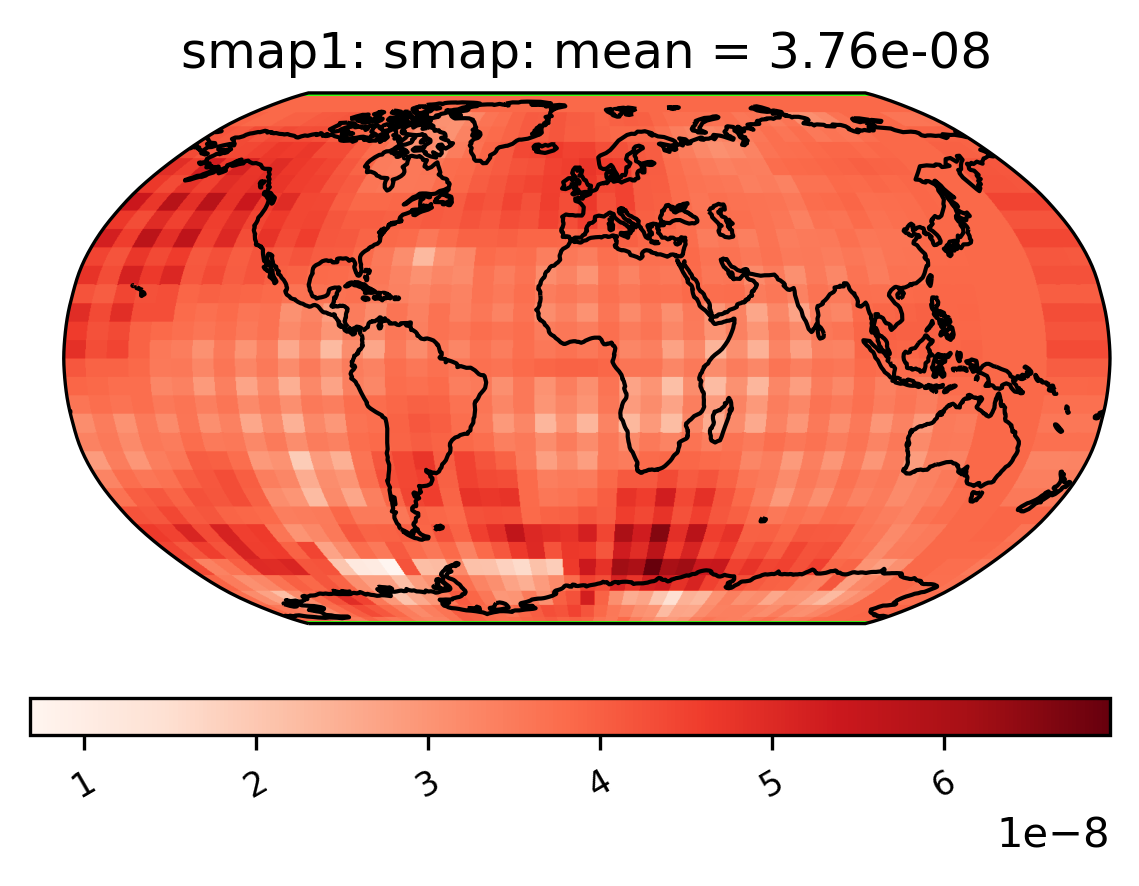

In [65]:
ds = ldcpy.open_datasets(data_type="cam-fv", varnames=[f"smap"], list_of_files=["./smaps/smap1_sub6_U10_full.nc"], labels=["smap1"], weights=False)

ds["smap"].attrs["units"] = ""
# ds2 = ldcpy.open_datasets(data_type="cam-fv", varnames=[f"smap"], list_of_files=["./smaps/smap2_sub6_full.nc"], labels=["smap2"], weights=False)
# ds_Q850 = ldcpy.open_datasets(data_type="cam-fv", varnames=[f"smap"], list_of_files=["./smaps/smap0_Q850.nc"], labels=["smap0"], weights=False)
ldcpy.plot(ds.squeeze(), sets=["smap1"], varname="smap", calc="mean", weighted=False, color="Reds", vert_plot=True)



In [68]:
np.shape(data_array)

(56, 1, 32, 48)

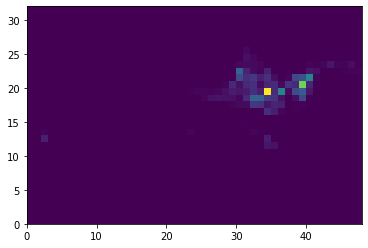

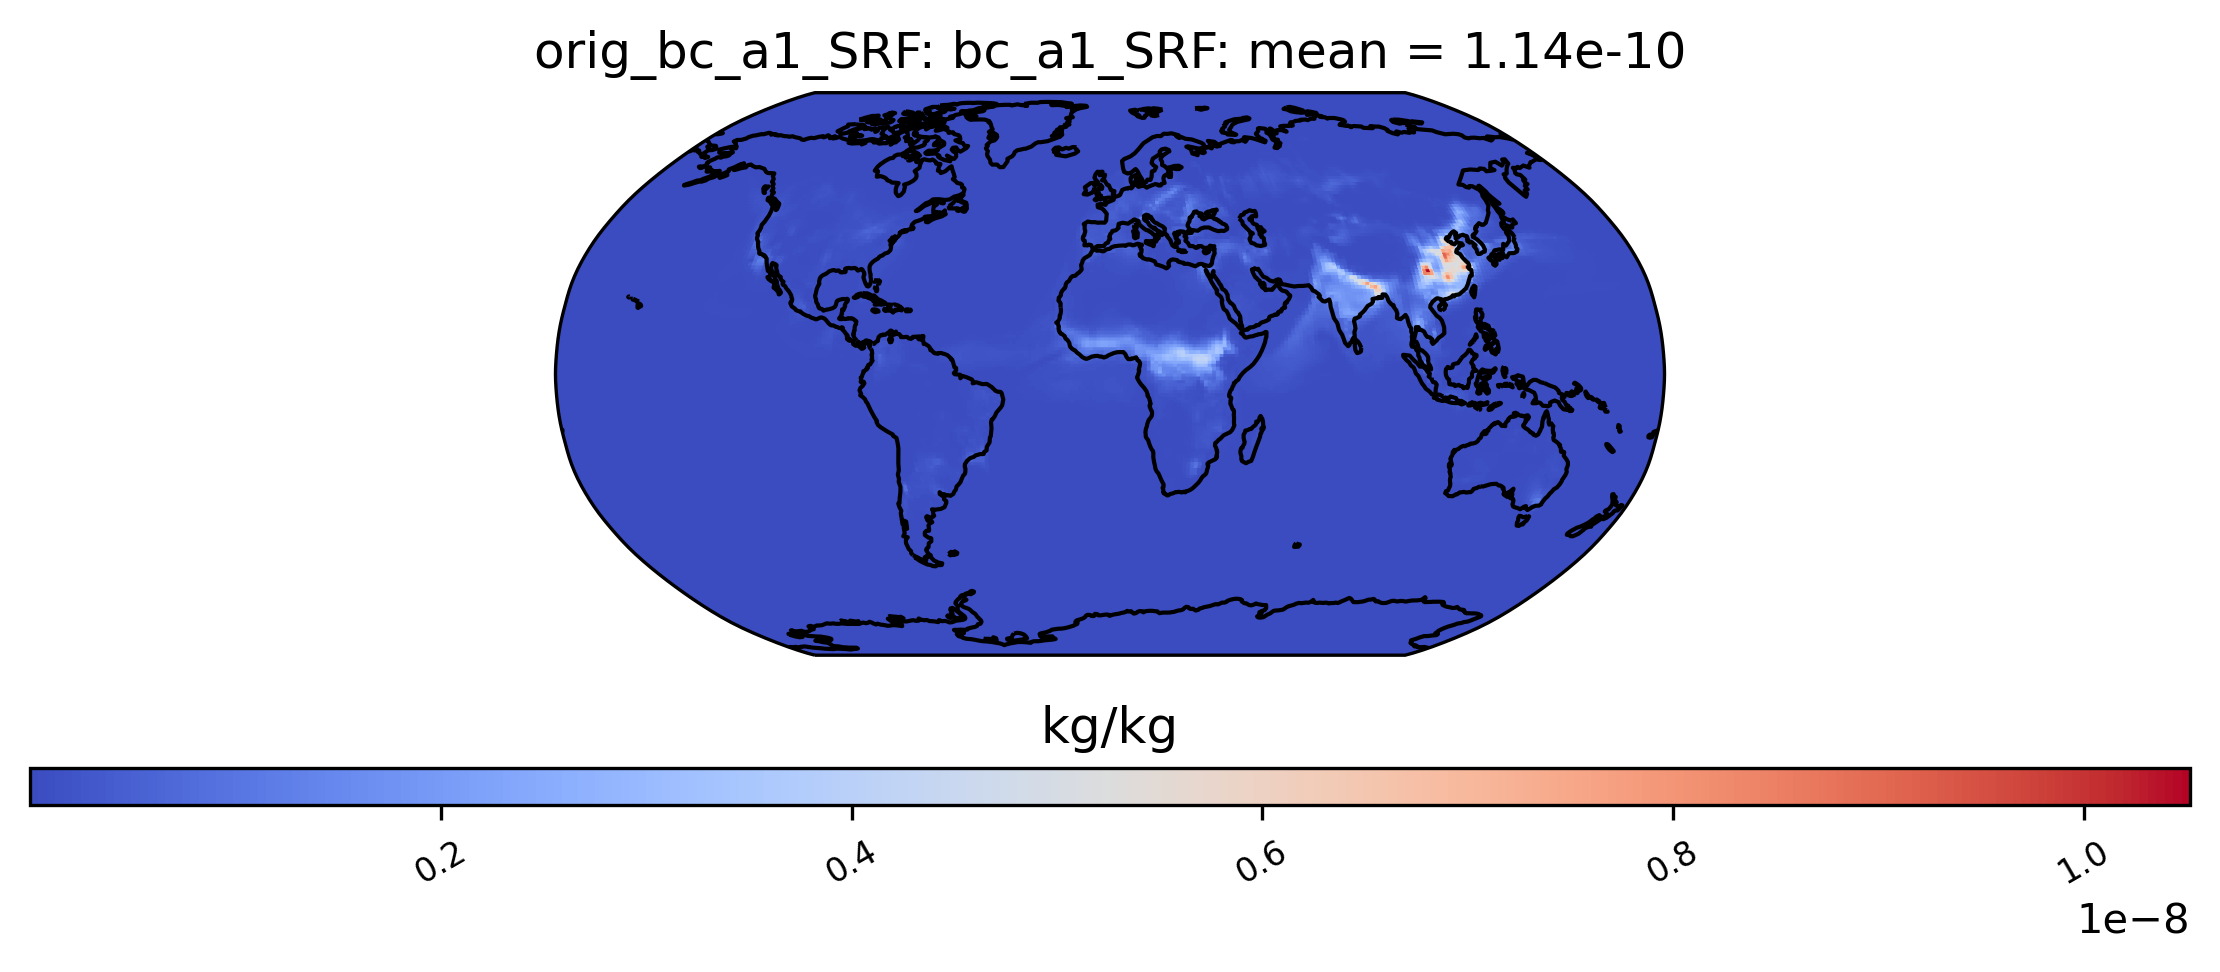

In [85]:
cur_v = "bc_a1_SRF"
s = np.roll(X_test[0])
plt.pcolormesh(s)
ldcpy.plot(cols_daily[cur_v], sets=[f"orig_{cur_v}"], varname=cur_v, calc="mean", start=0, end=1)

In [87]:
cols_daily[cur_v]

<xarray.Dataset>
Dimensions:     (collection: 7, time: 730, lat: 192, lon: 288)
Coordinates:
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time        (time) object 2006-01-01 00:00:00 ... 2007-12-31 00:00:00
    cell_area   (lat, collection, lon) float64 dask.array<chunksize=(192, 1, 288), meta=np.ndarray>
  * collection  (collection) <U14 'orig_bc_a1_SRF' ... 'bg_7_bc_a1_SRF'
Data variables:
    bc_a1_SRF   (collection, time, lat, lon) float32 dask.array<chunksize=(1, 700, 192, 288), meta=np.ndarray>
Attributes: (12/15)
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e11.BRCP85C5CNBDRD.f09_g16.031
    title:            UNSET
    logname:          mickelso
    host:             ys1023
    ...               ...
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...
    history:          Thu Mar 17 21:36:21 2022: ncks -d time,0,729,1 /glade/s...
    NCO:              netCDF Operators version 5.0.3 (Homepage = http://nco.s...
    cell_measures:    area: cell_area
    data_type:        cam-fv
    file_size:        {'orig_bc_a1_SRF': 130195620, 'bg_2_bc_a1_SRF': 4459519...

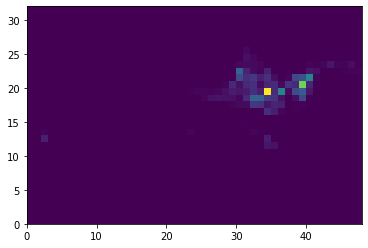

In [20]:
z_train = relabel_sequential(z_train.astype(int))
z_validate = relabel_sequential(z_validate.astype(int))
z_test = relabel_sequential(z_test.astype(int))


In [21]:
max(z_train[0]-1)

4

Epoch 1/5
503/503 [==============================] - 3s 6ms/step - loss: 1.2955 - accuracy: 0.4077 - val_loss: 1.1023 - val_accuracy: 0.4834
Epoch 2/5
503/503 [==============================] - 3s 6ms/step - loss: 1.2575 - accuracy: 0.4176 - val_loss: 1.1331 - val_accuracy: 0.4834
Epoch 3/5
503/503 [==============================] - 3s 6ms/step - loss: 1.2530 - accuracy: 0.4166 - val_loss: 1.1021 - val_accuracy: 0.4834
Epoch 4/5
503/503 [==============================] - 3s 6ms/step - loss: 1.2463 - accuracy: 0.4268 - val_loss: 1.1049 - val_accuracy: 0.4834
Epoch 5/5
141/141 [==============================] - 0s 2ms/step - loss: 27608.6895 - accuracy: 0.0600


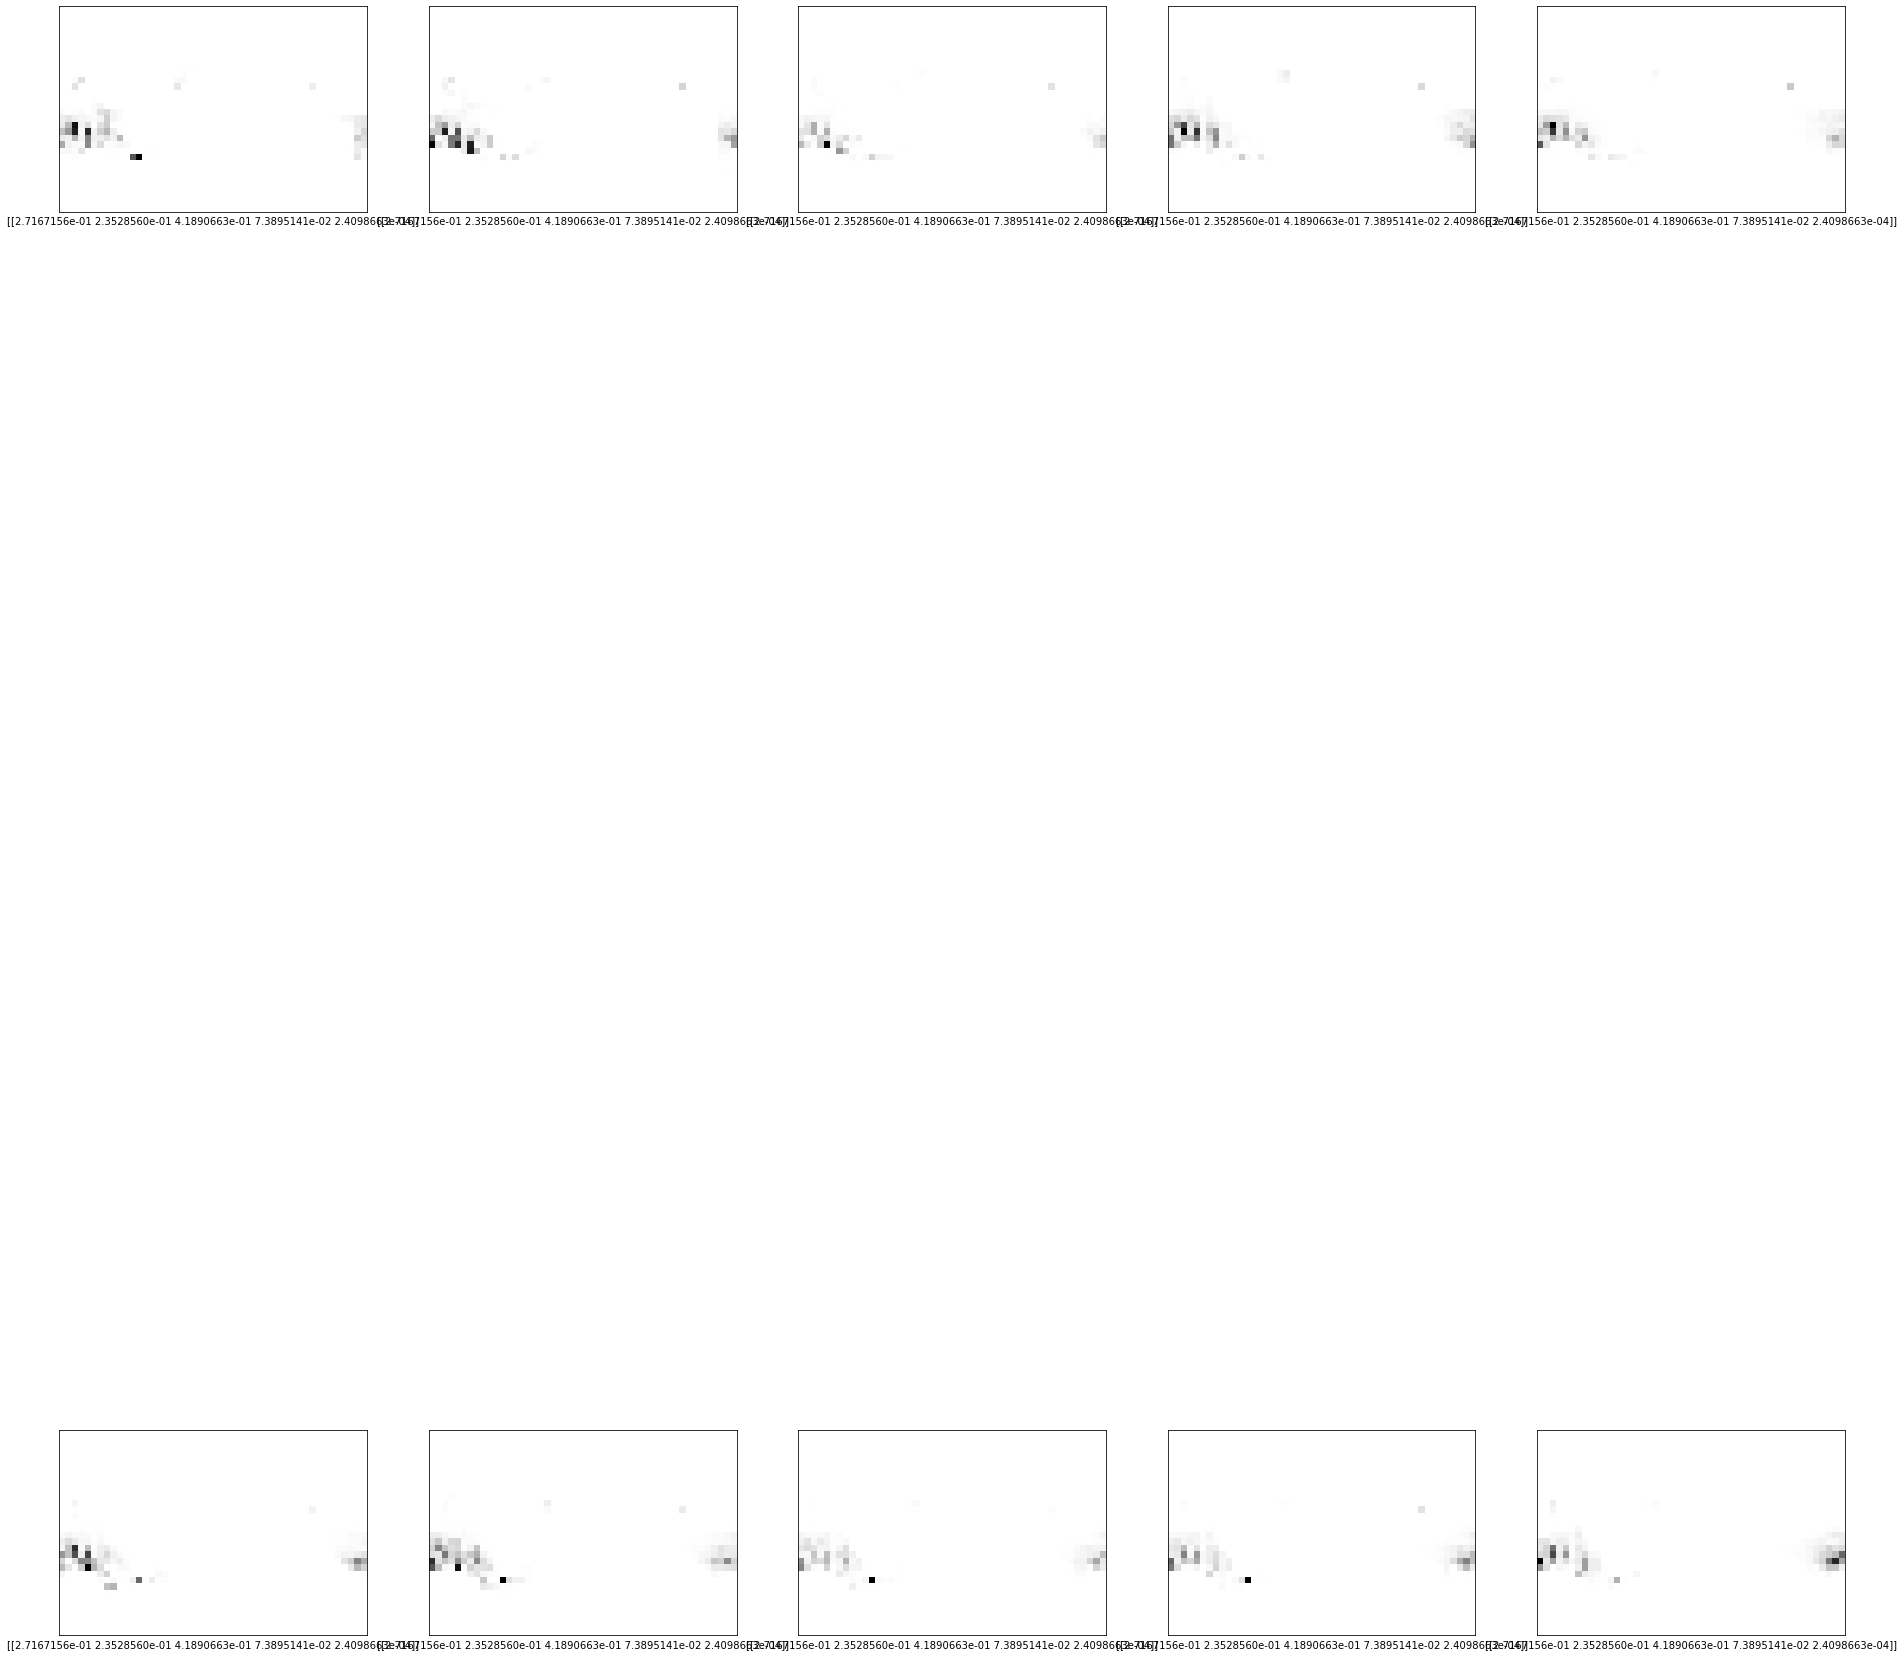

In [22]:
# A single-layer convolutional neural network that classifies input image of size 32x48 pixels to 3 classes.
# The network is trained on a subset of daily CAM variables from NCAR's CESM dataset.

import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.segmentation import relabel_sequential

def CNN(X_train, X_validate, X_test, y_train, y_validate, y_test):
    # Load the data
    

    # Normalize the data
    X_train = X_train / np.max(X_train)
    X_test = X_test / np.max(X_train)
    X_validate = X_validate / np.max(X_validate)


    # Reshape the data
    X_train = X_train.reshape(X_train.shape[0], 32, 48, 1)
    X_test = X_test.reshape(X_test.shape[0], 32, 48, 1)
    X_validate = X_validate.reshape(X_validate.shape[0], 32, 48, 1)


    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 48, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])


    # Compile the model
    model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])


    # Train the model
    model.fit(X_train, y_train, epochs=5, validation_data=(X_validate, y_validate))


    # Evaluate the model
    model.evaluate(X_test, y_test)


    # Predict the model
    model.predict(X_test[:10])


    # Plot the model
    plt.figure(figsize=(32, 48))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X_test[i], cmap=plt.cm.binary)
        plt.xlabel(model.predict(X_test[i:i+1]))
    plt.show()


    # Save the model
    model.save('CAM_CNN_model.h5')

CNN(V_train, V_validate, V_test, z_train[0]-1, z_validate[0]-1, z_test[0]-1)